# <Center> HW 4: Classification </center>

**Instructions**: 
- Please read the problem description carefully
- Make sure to complete all requirements (shown as bullets) . In general, it would be much easier if you complete the requirements in the order as shown in the problem description
- Please submit a py, a pdf file, and your jupyter notebook (optional).
- Code of academic integrity:
    - **Each assignment needs to be completed independently. This is NOT group assignment**. 
    - Never ever copy others' work (even with minor modification, e.g. changing variable names)
    - If you generate code using large lanaguage models (although it is not encouraged), make sure to adapt the generated code to meet all requirements and it is executable.
    - Anti-Plagiarism software will be used to check similarities between all submissions.
    - Check Syllabus for more details.

In this assignment, we use classification to identify deceptive comments. This assignment needs the following two data files:
- hw4_train.csv: dataset for training
- hw4_test.csv: dataset for testing
    
Both of them have samples in the following format. The `text` column contains documents and the `label` column gives the sentiment of each document.

|label | text |
|------|------|
|1|  when i first checked the hotel's website and r...|
|1|  I had really high hopes for this hotel. The lo...|
|0|  My experiences at the Fairmont Chicago were le...|
|...|...|


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, roc_auc_score, average_precision_score
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler


from IPython.core.interactiveshell import InteractiveShell
pd.options.display.float_format = "{:,.4f}".format
InteractiveShell.ast_node_interactivity = "all"

# fix seeds to ensure reproducibility of results
np.random.seed(2024) 

# add your import statements

In [2]:
train = pd.read_csv("hw4_train.csv")
train.head(3)
test = pd.read_csv("hw4_test.csv")
test.head(3)

,label,text
0,1,when i first checked the hotel's website and r...
1,1,I had really high hopes for this hotel. The lo...
2,1,Hotel Monaco is simply amazing. I travel quite...


,label,text
0,1,This is the hotel for the discriminating busin...
1,0,"What a wonderful experience, super great, help..."
2,0,I stayed at the Talbott twice in the last few ...


## Q1 Text Vectorization and Naive Bayes (5 points)


For classification, the first step is to compute the word TF-IDF weights for each document. A few options can be configured as given below.


Define a function `classify(train_docs, train_y, test_docs, test_y, binary=False, use_idf=True, stop_words=None, max_features=None, show_plots=False)`, where


- `train_docs`: is a list of documents for training.
- `train_y`: is the ground-truth labels of training documents.
- `test_docs`: is a list of documents for test.
- `test_y`: is the ground-truth labels of test documents.
- `classifier`: the name of classification algorithm. Two possible values: 'svm','naive bayes'. The default value is 'naive bayes'.
- `binary`: if true, within a document, the term frequency of a word is binarized to 1 if present and 0 otherwise. If False, the regular term frequency is considered. The default is False.
- `ngrams`: an option to include unigrams, bigrams, ..., nth grams. The default is (1,1), i.e., only unigrams used.
- `stop_words`: indicate whether stop words should be removed. The default value is 'english', i.e. remove English stopwords.
- `max_features`: the maximum number of features to be used. The default value is None, indicating all features are used.
- `show_plots`: controls whether to show classification report AND plots. The default is False.


This function does the following:
- Fit a `TfidfVectorizer` using `train_docs` with options `stop_words, max_features, ngrams, binary` as specified in the function inputs. Extract features from `train_docs` using the fitted `TfidfVectorizer`.
- Train a classifier by the specified `classifier` algorithm using the extracted features from `train_docs` and labels from `train_y`.
- Transform `test_docs` by the fitted `TfidfVectorizer` (hint: use function `transform` not `fit_transform`).
- Predict the labels for `test_docs` with trained model.
- If `show_plots` is True,
    - Print the classification report.
    - Plot the AUC score and PRC score (or Average Precision) for class 1 on the test dataset. On the plot, specify xlabel, ylabel on axis, and the scoring metrics (AUC/PRC/Average Precision) on the title.
    - Note, if the classifier is 'svm', you may use `decision_function` instead of predict_proba function. The details can be found at https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC.decision_function.
- Return the `TfidfVectorizer` and the trained model.
    

Test your function with following cases:
- `stop_words = 'english', max_features = 5000, binary = False, classifier='naive bayes', show_plots = True`
- `stop_words = 'english', max_features = 5000, binary = False, classifier='svm', show_plots = True`

In [3]:
def classify(train_docs, train_y, test_docs, test_y, \
                classifier = 'naive bayes',
                binary=False, ngrams = (1,1), \
                stop_words='english', max_features=None, \
                show_plots=True):
    
    # Fit a TfidfVectorizer using train_docs
    tfidf_vect = TfidfVectorizer(stop_words=stop_words, 
                                 max_features=max_features, 
                                 binary=binary,
                                 ngram_range=ngrams)
    train_data = tfidf_vect.fit_transform(train_docs)
    
    # Transform test_docs by the fitted TfidfVectorizer
    test_data = tfidf_vect.transform(test_docs)
    
    # Train a classifier by the spoecified classifier algorithm
    if classifier == 'naive bayes':
        model = MultinomialNB()
        clf = model.fit(train_data, train_y)
        pred_y = clf.predict(test_data)
        pred_prob_y = clf.predict_proba(test_data)[:, 1]
    elif classifier == 'svm':
        model = svm.LinearSVC()
        clf = model.fit(train_data, train_y)
        pred_y = clf.predict(test_data)
        decision_scores = clf.decision_function(test_data)
        scaler = MinMaxScaler()
        decision_scores_scaled = scaler.fit_transform(decision_scores.reshape(-1, 1))
        pred_prob_y = decision_scores_scaled.flatten()
    else:
        print("Please specify classifier as 'naive bayes' or 'svm'.")
        return None, None
    
    # If show_plots is True, then print the classification report and plot the AUC and PRC score
    if show_plots:
        print(classification_report(test_y, pred_y))
        fpr, tpr, thresholds = roc_curve(test_y, pred_prob_y, pos_label=1)
        precision, recall, thresholds = precision_recall_curve(test_y, pred_prob_y, pos_label=1)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        ax1.plot(fpr, tpr, color='darkorange', lw=2);
        ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax1.set_xlim([-0.05, 1.05])
        ax1.set_ylim([-0.05, 1.05])
        ax1.set_xlabel('False Positive Rate')
        ax1.set_ylabel('True Positive Rate')
        ax1.set_title('AUC')
        ax2.plot(recall, precision, color='darkorange', lw=2);
        ax2.set_xlim([-0.05, 1.05]);
        ax2.set_ylim([-0.05, 1.05]);
        ax2.set_xlabel('Recall');
        ax2.set_ylabel('Precision');
        ax2.set_title('PRC');
        plt.show()
    
    # Calculate AUC
    auc = roc_auc_score(test_y, pred_prob_y)

    # Calculate PRC
    prc = average_precision_score(test_y, pred_prob_y)
    
    print("AUC: {:.2f}%, PRC: {:.2f}%".format(auc*100, prc*100))
    
    return clf, tfidf_vect

              precision    recall  f1-score   support

           0       0.88      0.82      0.85       233
           1       0.84      0.89      0.86       247

    accuracy                           0.86       480
   macro avg       0.86      0.86      0.86       480
weighted avg       0.86      0.86      0.86       480



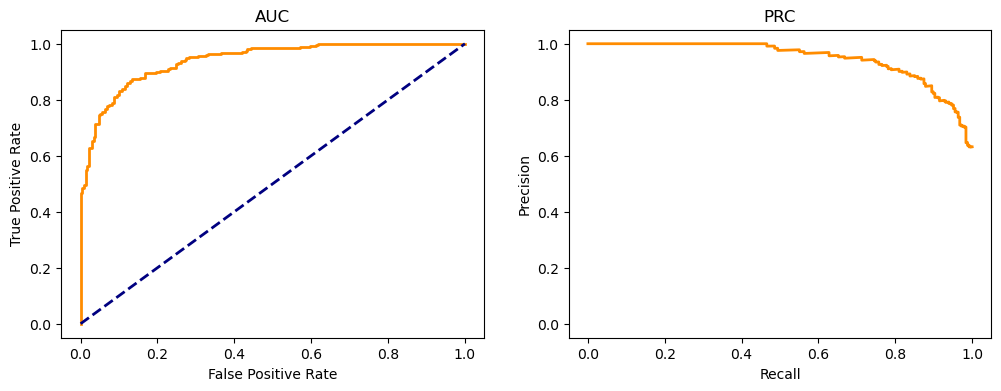

AUC: 94.16%, PRC: 94.86%


In [4]:
clf, vectorizer = classify(train["text"], train["label"],
                           test["text"], test["label"],
                           stop_words = 'english', binary = False, 
                           max_features = 5000,
                           classifier='naive bayes', show_plots = True)

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       233
           1       0.86      0.88      0.87       247

    accuracy                           0.86       480
   macro avg       0.86      0.86      0.86       480
weighted avg       0.86      0.86      0.86       480



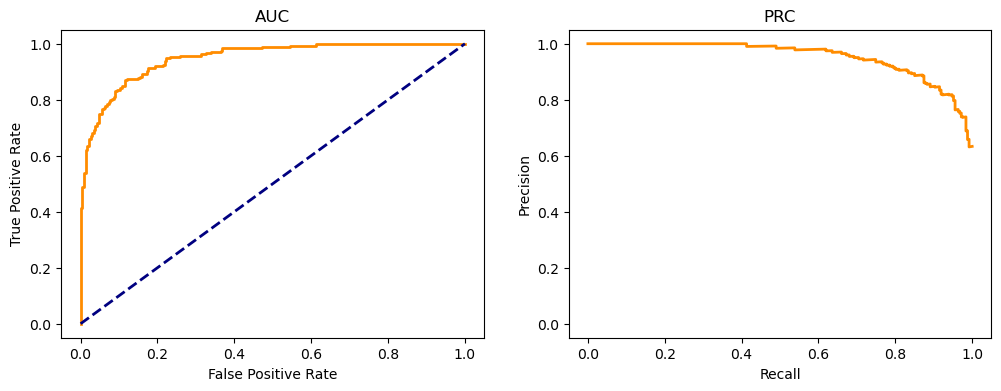

AUC: 94.85%, PRC: 95.39%


In [5]:
clf, vectorizer = classify(train["text"], train["label"],
                           test["text"], test["label"],
                           max_features = 5000,
                           stop_words = 'english', binary = False, 
                           classifier='svm', show_plots = True)

### Q2: Search for best parameters (2 points)


From Q1, you may find there are many possible ways to configure parameters. Next, let's use grid search to find the optimal parameters.

- Define a function `search_para(docs, y, classifier = 'naive bayes')` where `docs` are training documents, `y` is the ground-truth labels, and `classifier` is the model you use.
- This function does the following:
    - Create a pipleline which integrates `TfidfVectorizer` and the classifier as specified by parameter `classifier` . 
    - Define the parameter ranges as follow: 
        - `stop_words: [None, 'english']`
        - `max_features:[None, 5000]`
        - `ngram_range:[(1,1), (1,2)]`
        - `binary: [True, False]`
    - Set the scoring metric to `f1_macro`. 
    - Use `GridSearchCV` with `5-fold cross validation` to find the best parameter values based on the training dataset. 
    - Print the values of the `best` parameters combination. 
    
- Call this function to find `the best parameters combination` for linear SVM and Naive Bayes models. 
- Call the function `classify` again to use `the best parameters combination`


Please briefly answer the following: 
- Compared with the model in Q1, how is the performance improved on the test dataset?
- Why do you think the new parameter values help deceptive comment classification?

In [6]:
def search_para(docs, y, classifier = 'naive bayes'):

    # Define a specific classifier
    if classifier == 'naive bayes':
        model = MultinomialNB()
    elif classifier == 'svm':
        model = svm.LinearSVC()
    else:
        print("Please specify classifier as 'naive bayes' or 'svm'.")
    
    # Create a pipeline 
    text_clf = Pipeline([('tfidf', TfidfVectorizer()), ('clf', model)])
    parameters = {'tfidf__stop_words': [None, 'english'],
                  'tfidf__max_features': [None, 5000],
                  'tfidf__ngram_range': [(1, 1), (1, 2)], 
                  'tfidf__binary': [True, False]}

    # Find the best parameter values, using GridSearchCV with 5-fold cross validation
    gs_clf = GridSearchCV(text_clf, param_grid=parameters, scoring="f1_macro", cv=5)
    gs_clf = gs_clf.fit(docs, y)
    for param_name in gs_clf.best_params_:
        print("{0}:\t{1}".format(param_name, gs_clf.best_params_[param_name]))

    print("best f1 score: {:.3f}".format(gs_clf.best_score_))
    
    return None

In [7]:
search_para(train["text"], train["label"])

tfidf__binary:	True
tfidf__max_features:	5000
tfidf__ngram_range:	(1, 2)
tfidf__stop_words:	None
best f1 score: 0.891


In [8]:
search_para(train["text"], train["label"], classifier ='svm')

tfidf__binary:	True
tfidf__max_features:	None
tfidf__ngram_range:	(1, 2)
tfidf__stop_words:	None
best f1 score: 0.900


              precision    recall  f1-score   support

           0       0.89      0.86      0.87       233
           1       0.87      0.89      0.88       247

    accuracy                           0.88       480
   macro avg       0.88      0.88      0.88       480
weighted avg       0.88      0.88      0.88       480



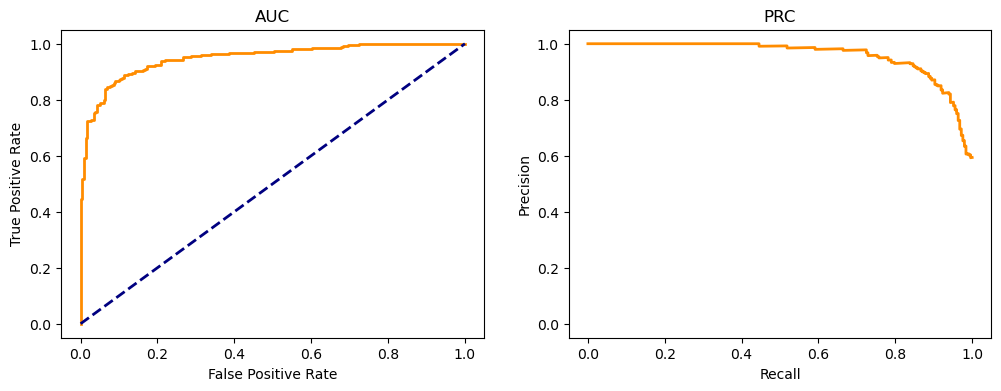

AUC: 94.97%, PRC: 95.87%


In [9]:
# retrain the model with the best parameter values you found
# You may get different parameter values

clf, vectorizer = classify(train["text"], train["label"],
                              test["text"], test["label"],
                              stop_words= None, max_features = 5000, 
                              binary=True, ngrams = (1,2), 
                              classifier = 'naive bayes', show_plots=True)

              precision    recall  f1-score   support

           0       0.90      0.85      0.87       233
           1       0.87      0.91      0.89       247

    accuracy                           0.88       480
   macro avg       0.88      0.88      0.88       480
weighted avg       0.88      0.88      0.88       480



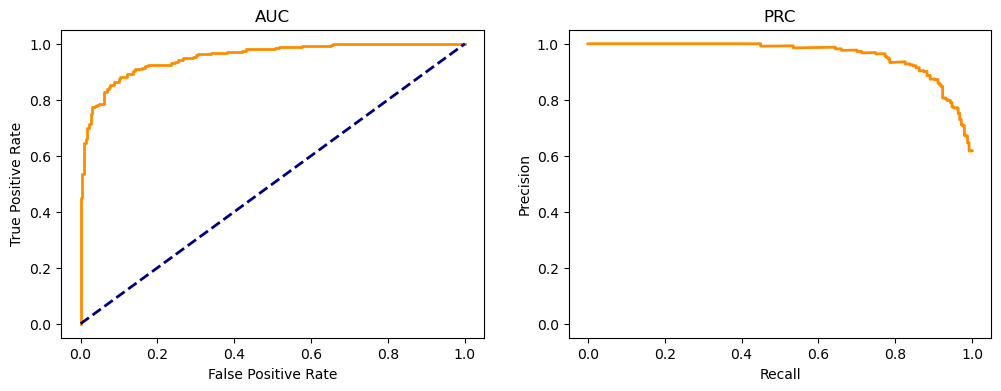

AUC: 95.33%, PRC: 96.07%


In [10]:
# retrain the model with the best parameter values you found
# You may get different parameter values

clf, vectorizer = classify(train["text"], train["label"],
                              test["text"], test["label"],
                              stop_words= None, 
                              max_features = None, 
                              binary=True,
                              ngrams = (1,2), 
                              classifier = 'svm', show_plots=True)

**Q: Compared with the model in Q1, how is the performance improved on the test dataset?**

A: The performance in Q2 is slightly better than Q1 because we use GridSearchCV to test and find the set of parameters that gives the highest performance.

**Q: Why do you think the new parameter values help deceptive comment classification?**

A: In Q2, we set 'binary' as True instead of False, and 'ngrams' as (1,2) instead of (1,1). Setting 'binary' as True makes the model focuses on the presence or absence of words or phrase which makes the model can better capture those deceptive comments that contain deceptive words or phrases. Setting 'ngrams' as (1,2) makes the model capture both unigram and bigram which make the model can capture more context that leads to better classify deceptive comments.

## Q3. Impact of Sample Size (3 points)

This task is to help you understand the impact of sample size on classifier performance. 

Define a function `show_sample_size_impact(train_docs, train_y, classifier = 'naive bayes')` where:
- `train_docs`: is a list of documents for training.
- `train_y`: is the ground-truth labels of training documents.
    
Conduct the experiment as follows:    
- Starting with 100 samples, in each round you build a classifier with 100 more samples. i.e. in round 1, you use samples from 0 to 100, and in round 2, you use samples from 0 to 200, …, until you use all samples. 
- In each round, you'll conduct `4-fold cross validation` as follows:
    - Train both Naive Bayes and Linear SVM models
    - Set the TFIDF vectorizer to remove English stopwords, set ngram range to (1,2), and set max_features to 5000.
    - Record the average testing F1-macro score.
    
    
- Plot a line chart to show the relationship between sample size and the F1-macro score for SVM and Naive Bayes models. 
- This function has no return.
    
    
- Write your analysis on the following:
    - How does sample size affect each classifier’s performance? 
    - If it is expensive to collect and label samples, can you decide an optimal sample size with model performance and the cost of samples both considered? 
  

In [11]:
def show_sample_size_impact(train_docs, train_y):
    
    # Initialize empty lists to store all required values for plotting
    f1_score_list_nb = []
    f1_score_list_svm = []
    x_axis = []
    
    # Set the TFIDF vectorizer to remove English stopwords, set ngram range to (1,2), and set max_features to 5000
    tfidf_vect = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features=5000)
    
    # Find the average F1-macro score for each round (increase 100 sample size per round)
    docs_size = len(train_docs)
    for i in range(docs_size // 100 + 1):
        if ((i + 1) * 100 > docs_size) or (docs_size < 100):
            f1_macro_score_nb, f1_macro_score_svm = classification_function(train_docs, train_y, tfidf_vect)
            x_axis.append(docs_size)
        else:
            f1_macro_score_nb, f1_macro_score_svm = classification_function(train_docs[:(i + 1) * 100], train_y[:(i + 1) * 100], tfidf_vect)
            x_axis.append((i + 1) * 100)
        f1_score_list_nb.append(f1_macro_score_nb)
        f1_score_list_svm.append(f1_macro_score_svm)
    
    # Plot a line char to show the relationship between sample size and the F1-macro score for SVM and Naive Bayes models
    plt.figure()
    plt.plot(x_axis, f1_score_list_nb, label='Naive Bayes')
    plt.plot(x_axis, f1_score_list_svm, label='SVM')
    plt.xlabel('Sample Size')
    plt.ylabel('F1-macro Score')
    plt.title('Effect of Sample Size on Classifier Performance')
    plt.legend()
    plt.show()
    

def classification_function(train_docs, train_y, tfidf_vect):
    
    # Function to find the average F1-macro score
    train_data = tfidf_vect.fit_transform(train_docs) 
    clf_nb = MultinomialNB()
    clf_svm = svm.LinearSVC()
    cv_nb = cross_validate(clf_nb, train_data, train_y, scoring="f1_macro", cv=4, return_train_score=True)
    cv_svm = cross_validate(clf_svm, train_data, train_y, scoring="f1_macro", cv=4, return_train_score=True)
    average_f1_macro_score_nb = sum(cv_nb['test_score']) / len(cv_nb['test_score'])
    average_f1_macro_score_svm = sum(cv_svm['test_score']) / len(cv_svm['test_score'])
    
    return average_f1_macro_score_nb, average_f1_macro_score_svm


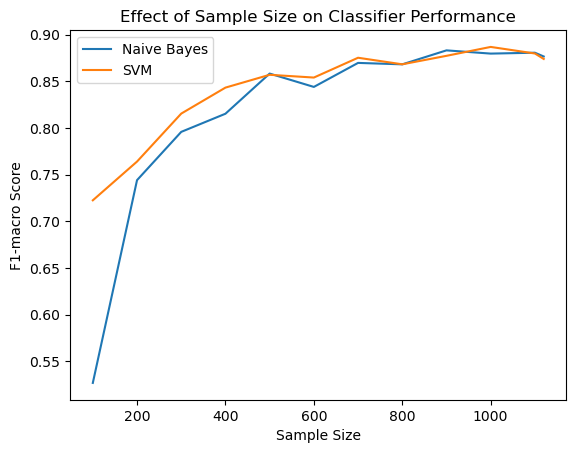

In [12]:
show_sample_size_impact(train["text"], train["label"])

**Q: How does sample size affect each classifier’s performance?**

A: Initially, an increase in sample size significantly increases the performance of each classifier, but the SVM performs better at a few sample sizes. As we continue to increase the sample size, the performance of each classifier tends to plateau, and there is less difference between them.

**Q: If it is expensive to collect and label samples, can you decide an optimal sample size with model performance and the cost of samples both considered?**

A: If cost matters, then we should conduct experiments with different sample sizes and visualize the results to find the optimal point or the point of diminishing returns, where further increases in sample size lead to only marginal improvements in performance. Then, we can select the sample size that matches the cost most effectively.

## Q4 (Bonus): Model Interpretation (2 points)


For this dataset, both Naive Bayes and SVM model can provide good classification accuracy. How does the models conclude that a document is deceptive? What features have the discriminative power?


Let's consider the models you trained in Q2 with the best parameter values. Two test documents have been provided below. The ground truth of the first document is 0 and the second one is 1. For each document, can you show the following:

1. What are the top-10 most important features used by each classifier to produce the predictionS? 
1. Do the two models agree on the most important features?
1. Based on the intepretation, which model do you trust more? 


Implement an explanation model here and answer questions 1-3.

In [13]:
docs = ['''We visited for my 40th birthday. We had never been to Chicago so was not sure where to stay. 
           Found the deal on this hotel from Travelzoo.
           Great rate, staff was awesome, very helpful and nice, location was great. 
           Enjoyed our stay but still like NYC better. Great, great hotel. Would stay again.''',
        '''My experience at the Hyatt Regency Chicago was simply amazing. 
           I had a wonderful stay there will my husband. 
           My husband has allergy problems nearly everywhere we go, and we were worried about that so we talked to the desk clerk there. 
           They were able to provide us with a Hyatt allergy-friendly room. 
           We were so relieved and the room was beautiful. 
           The furniture in the room was actually cleaned with pure tea tree oil. 
           It was the most comfortable stay we have ever had. 
           On top of that my husband had to spend some time in the room working on some business, 
           so the high speed internet they provided was very convenient. 
           We took full advantage of the 24 hour room service. 
           I will definitely stay there again. It is a vacation simply staying in your hotel room.''']

labels = [0, 1]